# Self Driving Car 
## Convolutional Neural Network (CNN)
This project is to develop a Behavioural Bloning SDC using a deep neural network 

### System Pipeline Overview
<ul>
<li>Data Collection</li>
<li>Data Augmentation</li>
<li>Data Preprocess</li>
<li>Define the Model</li>
<li>Train the Model</li>
<li>Test the Model</li>
</ul>

In [7]:
# Necessary imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Data Collection
The driving information was collected in a simulated environment to make it easy to record all the car controls and the environment the car sees infront of it through 3 cameras. The car was driven around two tracks in the simulator multiple times and in different directions or focusing on different parts to collect a balanced and varied data so that the neural network will be able to handle many different situations.

In [8]:
track_log_path = ['jungleTrack', 'lsdTrack']


#select correct column for csv
columns = ['centre cam', 'left cam' , 'right cam ', 'steering', 'throttle', 'brake', 'speed']

def parse_logs(track_log_path):
    '''
    Parse the driving logs, customise the image paths and concatenate all the logs in a single Pandas
    DataFrame
    :params log_paths: List of all the driving log paths
    :return: Pandas DataFrame
    '''
    frames = []
    for i, track_log_path in enumerate(track_log_path):
        df = pd.read_csv(track_log_path + '/driving_log.csv')
        global columns
        df.columns = columns
        
        for column in columns[:3]:
            df[column] = df[column].apply(lambda x: '/'.join(x.split('/')[-3:]))

        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = parse_logs(track_log_path)
image = cv2.imread(df.loc[0]['centre cam'].strip())

In [9]:
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    print('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    return


print('Number of scene frames: {} /20,000'.format(len(df)))
progress(len(df),20000,"Data Collection Progress")
print('\nIdeally we want a sample set of about 20,00 for balance and variety')
print('Total frames Left,Right and Centre prespectives): {} /60,000'.format(len(df) * 3))
print('Image shape: {}'.format(image.shape))

Number of scene frames: 3893 /20,000
[============------------------------------------------------] 19.5% ...Data Collection Progress

Ideally we want a sample set of about 20,00 for balance and variety
Total frames Left,Right and Centre prespectives): 11679 /60,000
Image shape: (160, 320, 3)


Avg # samples/bin: 155.72
Threshold 202


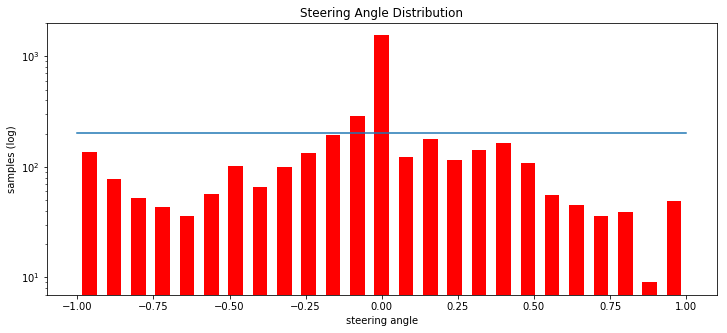

In [10]:
# Visualising the steering angle distribution

#size of steering angle bins
binSize = 25 

hist, bins = np.histogram(df.steering, binSize)
center = (bins[:-1] + bins[1:])/2

plt.figure(figsize=(12,5))
plt.bar(center, hist, align='center', width=(bins[0] - bins[1])*0.6, log=True, fc='r', color='b')
plt.title('Steering Angle Distribution')
plt.ylabel('samples (log)')
plt.xlabel('steering angle')
avg_nb_samples = len(df['steering']) / binSize
threshold = int(avg_nb_samples * 1.3)
plt.plot((df['steering'].min(), df['steering'].max()), (threshold, threshold))

print('Avg # samples/bin: {}'.format(avg_nb_samples))
print('Threshold {}'.format(threshold))

## Description:
This is a graph of the steering angle recorded for each frame during a drive around the simulator. The Data is skewed towards the center which will give our neural network poor learning material. Balance and variety are very important to sufficiently train our model.
Reasons for skewed data: 
<ul>
<li>Track: This course contains a lot of straights or gently turns meaning it doesn't require as many extreme steering angles</li>
<li>Sample Size: If the data is from one lap, around one track, in one direction for example. To accomplish a more balanced sample set we will need to record multiple laps on different tracks and in different directions</li>
<li>Specialisation: We may want to record particular turns or environments multiple times such as sharp bends. It would have undoubtedly helped balance out the data in this case.</li>
<li>Data Selection: This is the whole set of data recorded is very skewed towards the center because the tracks contain many straights. We could how ever decide to purposely omit data, such as the large number of low steering angles, to have a more balanced training set </li>
</ul>
In the graph above I have marked the cut off point above which I will discard any more data. This will give a more balanced data set.
